# AF Classification from a Short Single Lead ECG Recording: The PhysioNet/Computing in Cardiology Challenge 2017

## Dowbload data

Download from https://physionet.org/content/challenge-2017/1.0.0/ and unzip to `data/challenge-2017`

## Setup Data

In [4]:
import numpy as np
import pandas as pd
import time
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm

root_folder = Path(input("Enter the folder path: "))
assert root_folder.exists(), "The folder does not exist"
assert (root_folder / "data/challenge-2017/training").exists(), "The folder does not exist"


In [6]:
from biosppy.signals import ecg
from scipy.signal import resample

def split_beat(signal, input_fs=512, output_fs=125, pad=60, padding_size=187):
    out = ecg.ecg(signal=signal, sampling_rate=input_fs, show=False)
    rpeaks = np.zeros_like(signal, dtype='float')
    rpeaks[out['rpeaks']] = 1.0

    # Split into individual heartbeats. For each heartbeat
    # record, append classification (normal/abnormal).
    beats = np.split(signal, out['rpeaks'])
    final_beats = []
    for idx, idxval in enumerate(out['rpeaks']):
        firstround = idx == 0
        lastround = idx == len(beats) - 1

        # Skip first and last beat.
        if (firstround or lastround):
            continue

        # Append some extra readings from next beat.
        beats[idx] = np.append(beats[idx], beats[idx+1][:pad])

        # Normalize the readings to a 0-1 range for ML purposes.
        beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

        # Resample from 360Hz to 125Hz
        newsize = int((beats[idx].size * output_fs / input_fs) + 0.5)
        beats[idx] = resample(beats[idx], newsize)

        # Skipping records that are too long.
        if (beats[idx].size > 187 + pad):
            continue
        elif (beats[idx].size > 187):
            beats[idx] = beats[idx][:187]

        # Pad with zeroes.
        zerocount = padding_size - beats[idx].size
        beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))
        final_beats.append(beats[idx])
        
    return np.array(final_beats)

def load_data(data_path, exclude=set(), beat_length=600, skip_length=500, max_peaks=20):
    reference = pd.read_csv(data_path / "REFERENCE.csv", header=None).to_numpy()
    data_x = []
    data_y = []
    names = []
    for r in reference:
        file_name, label = r[0], r[1]
        if file_name in exclude:
            continue
        assert (data_path / f"{file_name}.mat").exists(), f"{file_name}.mat does not exist"
        assert (data_path / f"{file_name}.hea").exists(), f"{file_name}.hea does not exist"
        data = scipy.io.loadmat(data_path / f"{file_name}.mat")['val'][0]
        for peak in split_beat(data, input_fs=300, pad=30):
            data_x.append(peak)
            data_y.append(label)
            names.append(file_name)
    
    data_x, data_y, names = np.array(data_x), np.array(data_y), np.array(names)
    # shuffle_indices = np.random.permutation(len(data_y))
    # data_x = data_x[shuffle_indices]
    # data_y = data_y[shuffle_indices]
    # names = names[shuffle_indices]
            
    return data_x, data_y, names


test_path = root_folder / "data/challenge-2017/validation"
test_x, test_y, test_names = load_data(test_path)
train_path = root_folder / "data/challenge-2017/training"
train_x, train_y, train_names = load_data(train_path, exclude=set(test_names))
train_x.shape, train_y.shape,test_x.shape, test_y.shape

((320943, 187), (320943,), (12285, 187), (12285,))

('A00001', 'N')

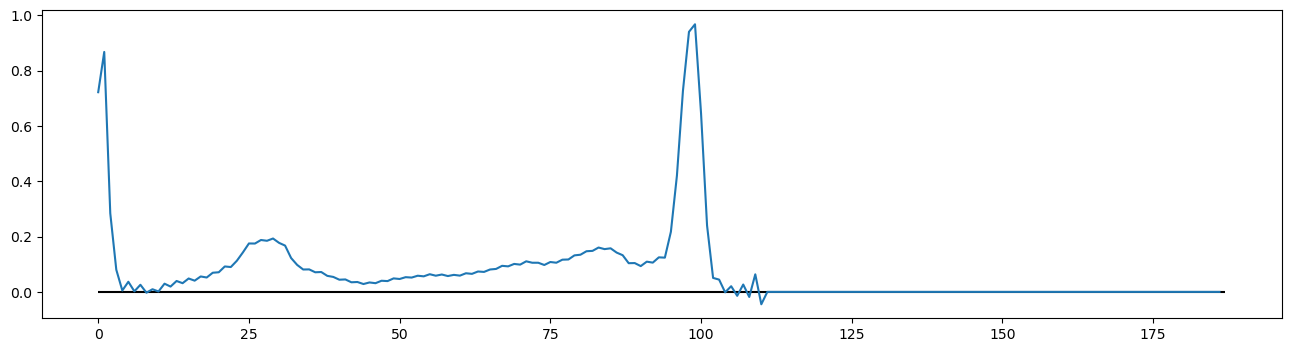

In [13]:
plt.figure(figsize=(16, 4))
plt.hlines(0, 0, len(test_x[0]), colors='black', linestyles='solid')
plt.plot(range(len(test_x[0])), test_x[12])
test_names[12], test_y[12]
# Downsample by taking the maximum of each non-overlapping window of size 2
# downsampled_data = np.maximum(test_x[100][::2], test_x[100][1::2])

# plt.plot(range(len(downsampled_data)), downsampled_data)

0.009401885505960661 159065 N N
0.014129289102763676 178237 ~ N


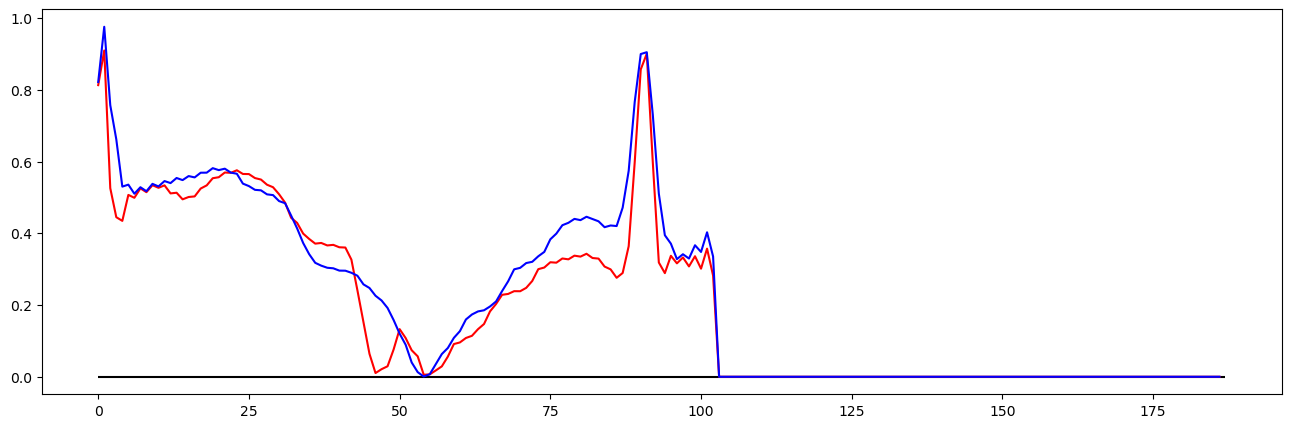

0.008713830427438674 162937 N N
0.0061971317074807075 31410 N N
0.010224406822657794 154396 O N


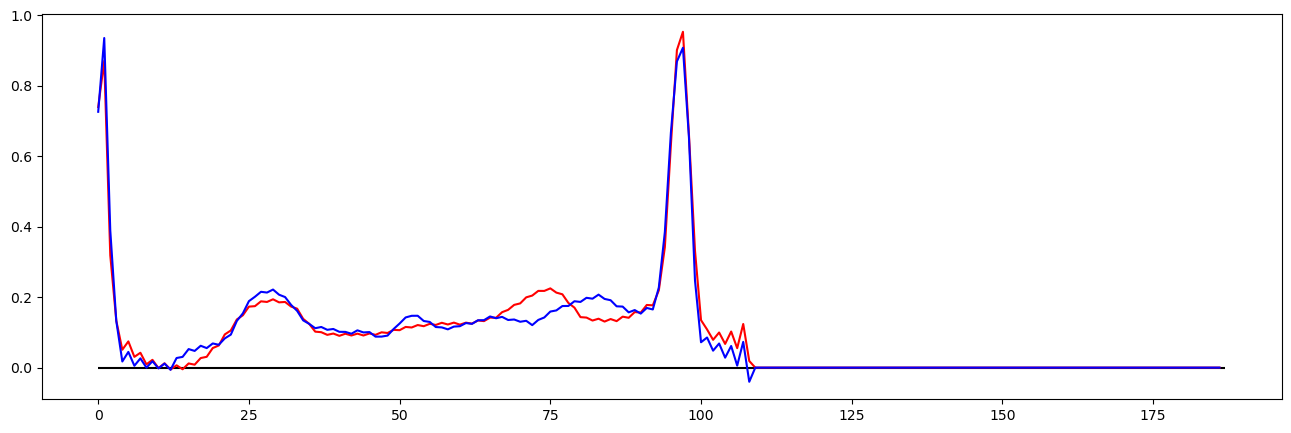

0.00439524567605476 116175 O N


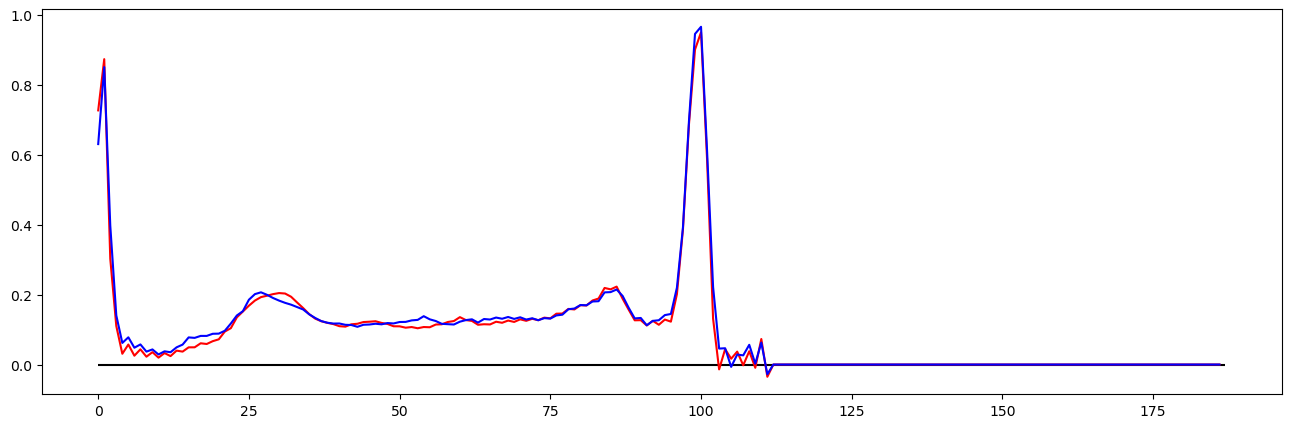

0.007303552160308979 59739 N N
0.007741826257768092 109242 O N


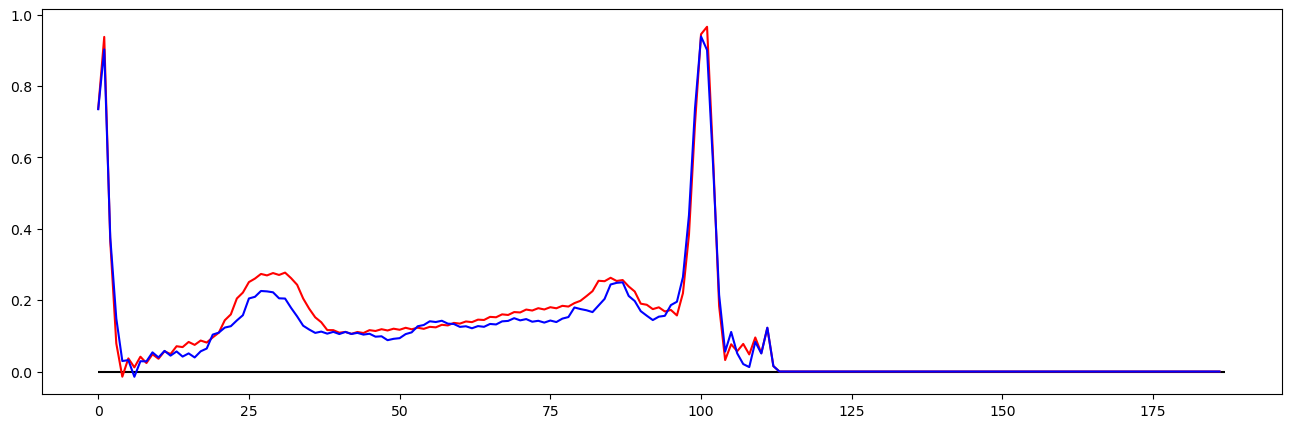

0.023365194327249705 221171 O N


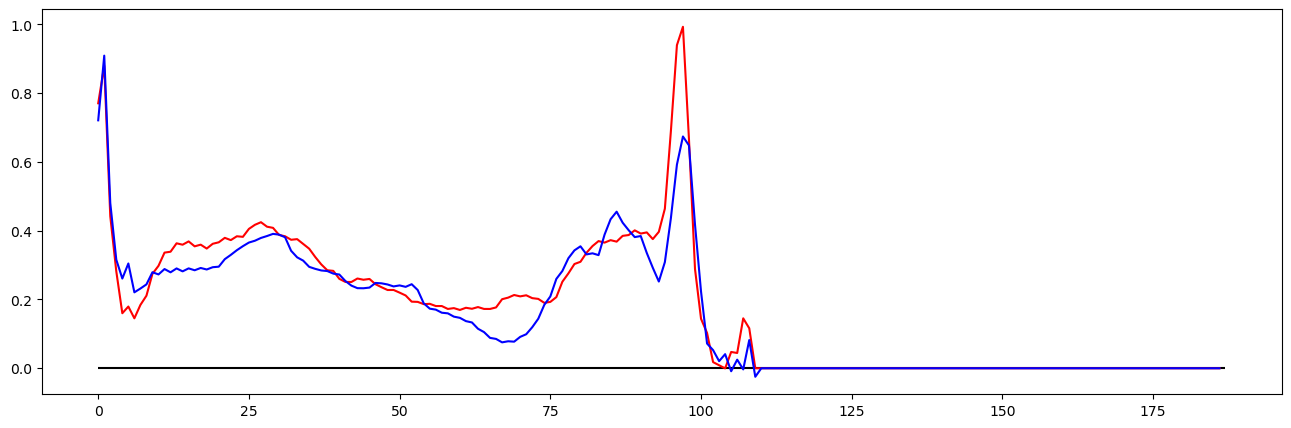

0.01792074512675257 177989 O N


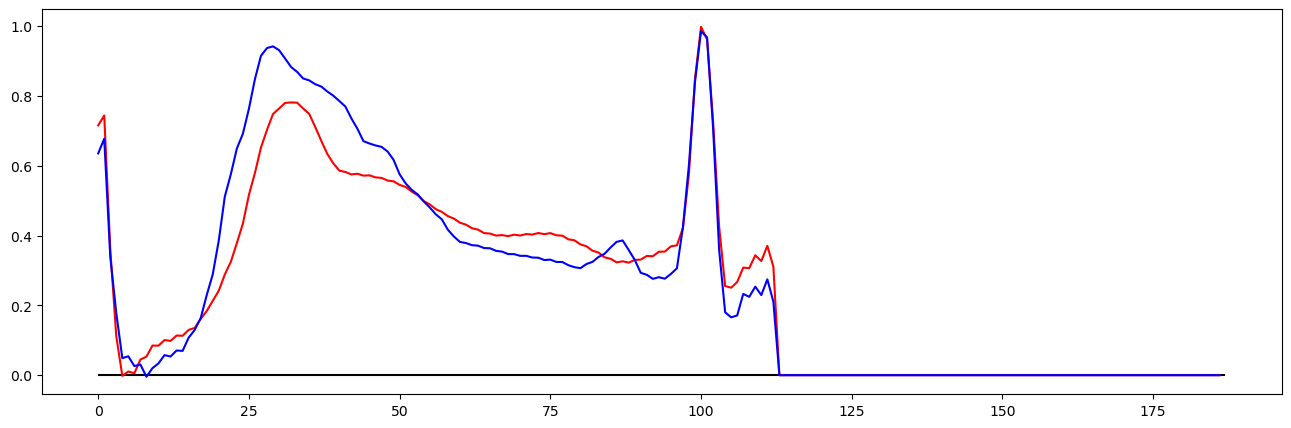

0.009008692550237174 11758 N N
0.005355486154142719 116175 O N


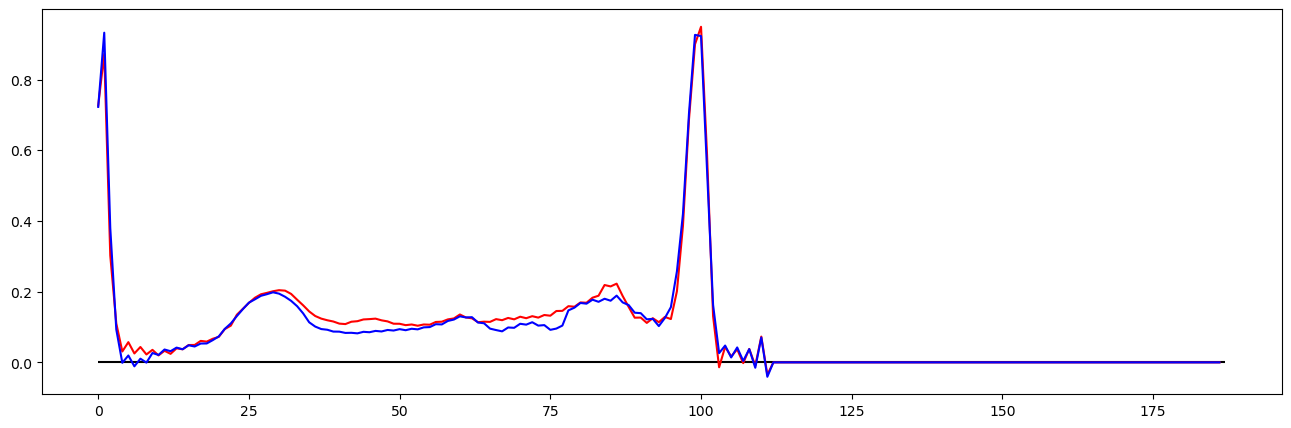

0.010183090570687559 275420 N N
0.006939686558059099 59739 N N
0.0063970955562836496 109252 O N


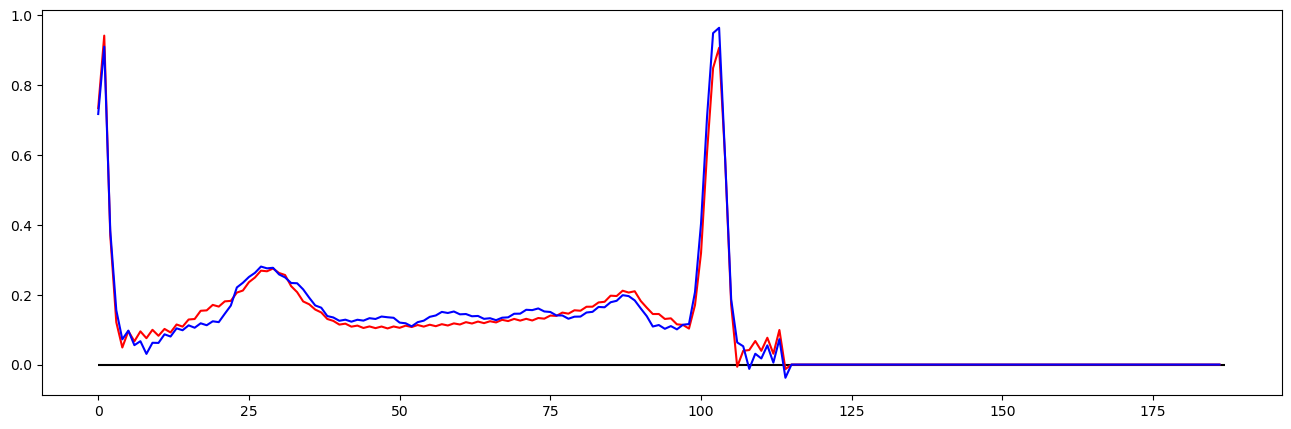

0.009534690918170163 89974 N N
0.011392860499049862 123559 O N


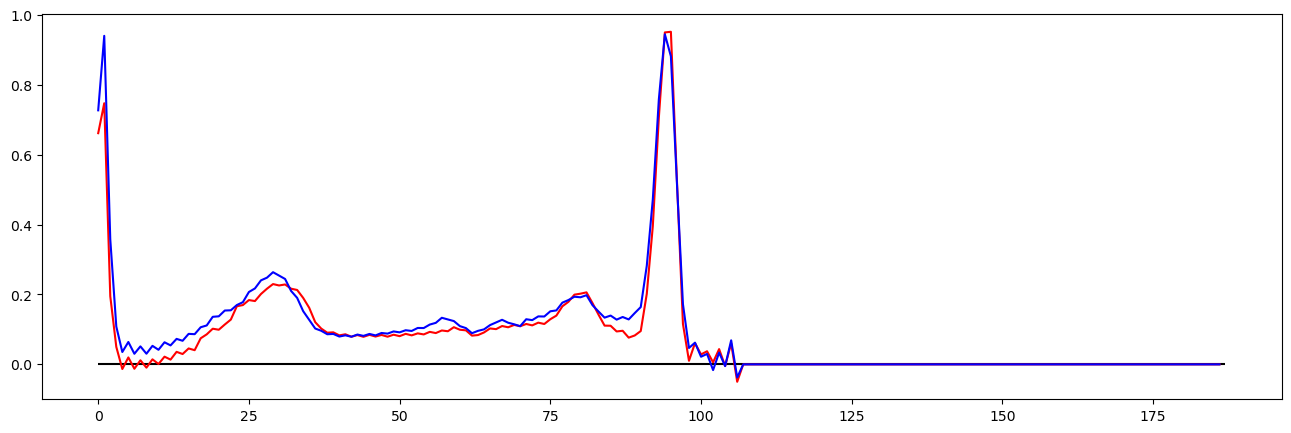

0.008087722796894181 124069 N N
0.010293971173827021 119983 N N
0.007062569455416834 46494 O N


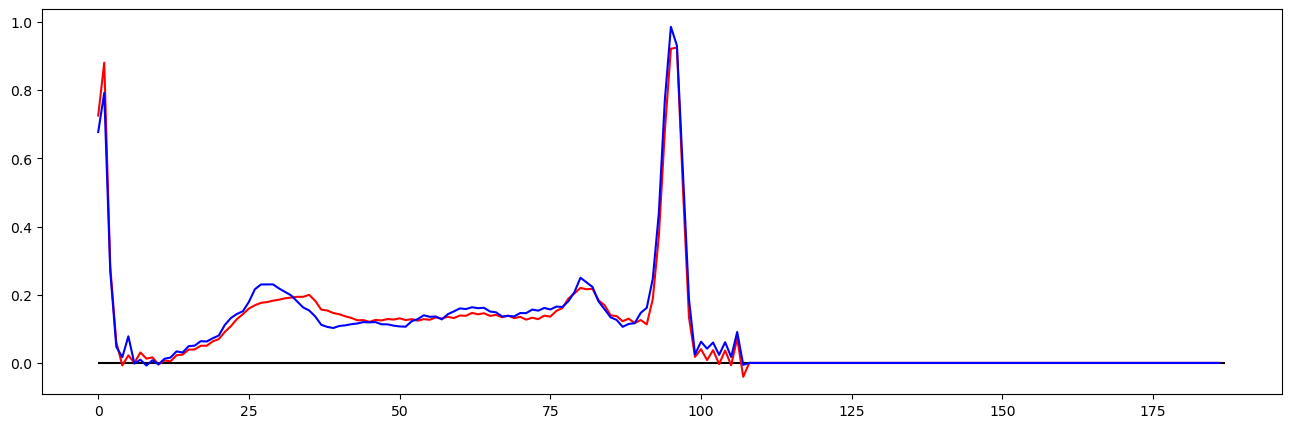

0.007082327477158201 89994 N N
0.009366937815693754 227616 N N
0.010197469741591969 240413 A N


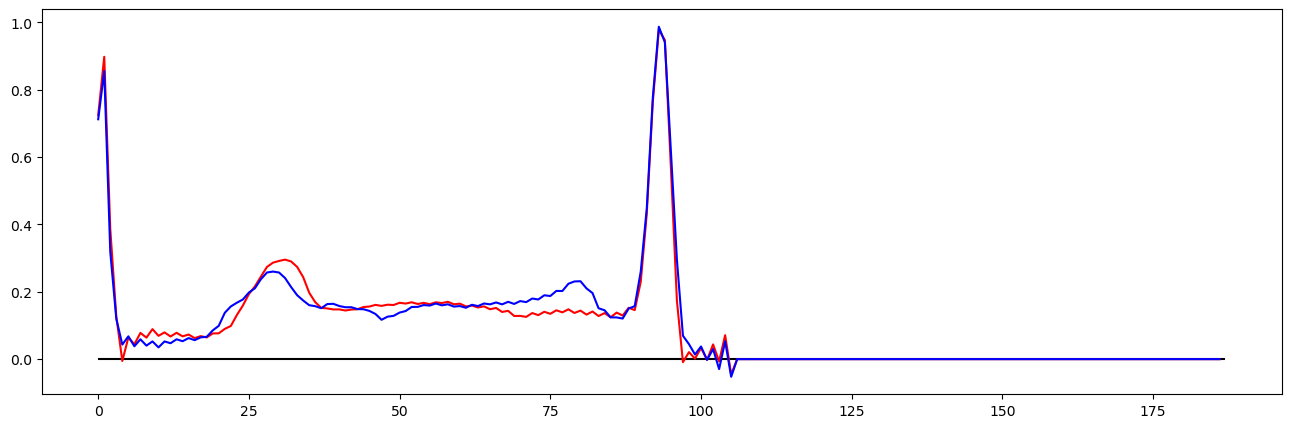

Accuracy: 0.521739


In [14]:
def cosine_distance(a, b):
    """
    Calculate the cosine distance between two vectors.
    a, b: NumPy arrays.
    """
    cosine_similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return 1 - cosine_similarity

def euclidean_distance(a, b):
    """
    Calculate the Euclidean distance between two vectors.
    a, b: NumPy arrays.
    """
    return np.linalg.norm(a - b)

def dot_product(a, b):
    """
    Calculate the dot product between two vectors.
    a, b: NumPy arrays.
    """
    return np.dot(a, b)

distance_func = cosine_distance
total, correct = 0, 0
for j, tx in enumerate(test_x[:100]):
    min_dis = float('inf')
    min_i = -1
    label = ''
    min_data = []
    for i, data_x in enumerate(train_x):
        # print(data_x.shape)
        dist = distance_func((data_x), (tx))
        if min_dis > dist:
            min_dis = dist
            min_i = i
            label = train_y[i]
            min_data = data_x
    print(min_dis, min_i, label, test_y[j])
    total += 1
    if label == test_y[j]:
        correct += 1
    else:
        plt.figure(figsize=(16, 5))
        plt.hlines(0, 0, len(test_x[0]), colors='black', linestyles='solid')
        plt.plot(range(len(min_data)), min_data, color='red')
        plt.plot(range(len(tx)), tx, color='blue')
        plt.show()
        # break
        if total - correct > 10:
            break
        
    
print(f'Accuracy: {correct / total:.6f}')

## Use Pinecone

In [20]:
import os
import pinecone
import json

try:
    pinecone_config = json.load(open(root_folder / 'pinecone.config.json'))
except FileNotFoundError as e:
    print("Pinecone.json not found. Please copy ./pinecone-template.config.json and fill in the values.")
    raise e

# get api key from app.pinecone.io
PINECONE_API_KEY = os.environ.get('PINECONE_API_KEY') or pinecone_config['PINECONE_API_KEY']
# find your environment next to the api key in pinecone console
PINECONE_ENV = os.environ.get('PINECONE_ENVIRONMENT') or pinecone_config['PINECONE_ENVIRONMENT']

pinecone.init(
    api_key=PINECONE_API_KEY,
    environment=PINECONE_ENV
)

### Get Index

In [30]:

def get_pinecone_index(index_name, metric="cosine"):
    assert metric in ['cosine', 'euclidean', 'dotproduct']
    # only create index if it doesn't exist
    if index_name not in pinecone.list_indexes():
        pinecone.create_index(
            name=index_name,
            dimension=train_x.shape[1],
            metric=metric
        )
        # wait a moment for the index to be fully initialized
        time.sleep(1)

    # now connect to the index
    index = pinecone.GRPCIndex(index_name)
    return index

index_base_name = "af-challenge2017"
index_name = f'{index_base_name}-c'
index = get_pinecone_index(index_name, 'cosine')

### Upload Vectors

In [26]:
def upload_vector(train_x, train_y, names):
    print(len(train_x), len(train_y))

    temp = {'id': [], 'embeddings': [], 'metadata': []}
    for i in range(train_x.shape[0]):
        temp['id'].append(i)
        temp['embeddings'].append(train_x[i])
        tempdict = dict()
        tempdict['label'] = str(train_y[i])
        tempdict['name'] = str(names[i])
        temp['metadata'].append(tempdict)
        
    train_df_vec = pd.DataFrame.from_dict(temp)

    def chunker(seq, size):
        'Yields a series of slices of the original iterable, up to the limit of what size is.'
        for pos in range(0, len(seq), size):
            yield seq.iloc[pos:pos + size]

    def convert_data(chunk):
        'Converts a pandas dataframe to be a simple list of tuples, formatted how the `upsert()` method in the Pinecone Python client expects.'
        data = []
        for i in chunk.to_dict('records'):
            if 'metadata' in i:
                data.append((str(i['id']),i['embeddings'],i['metadata']))
            else:
                data.append((str(i['id']),i['embeddings']))
        return data


    for chunk in chunker(train_df_vec, 100):
        index.upsert(vectors=convert_data(chunk))

upload_vector(train_x, train_y, train_names)
# upload_vector(train_balanced_x, train_balanced_y)

320943 320943


### Run Test

In [31]:
from collections import defaultdict
import json

def run_test(index, test_x, test_y, file='total_results', topk=10):

    def query(res):
        label_count = defaultdict(int)
        for match in res['matches']:
            label_count[match.metadata['label']] += 1
        
        max_count = max(label_count.values())  # Find the maximum count value
        max_keys = [key for key, count in label_count.items() if count == max_count]  # Find all keys with the max count

        return label_count, max_keys, res['matches'][0].metadata['label']

    total, top1, correct = 0, 0, 0
    total_results = []
    total_query = []
    matrix = {}
    for k in set(test_y):
        matrix[k] = {}
        for j in set(test_y):
            matrix[k][j] = 0
    print(matrix)
    for i, test_1 in enumerate(test_x):
        res = index.query(
            vector=test_1,
            top_k=topk,
            include_metadata=True
        )
        label = str(test_y[i])
        total_results.append((label, res.to_dict()['matches']))
        if len(res['matches']) == 10:
            total += 1
            q = query(res)
            total_query.append(q)
            # print(i, label, q[1:])
            matrix[label][q[2]] += 1
            if str(q[2]) == label:
                top1 += 1
            if str(q[1][0]) == label:
                correct += 1

    print(f'Total results: {total}')
    print(f"Top1: {top1}")
    print(f"Correct: {correct}")
    print(f"Top 1 Accuracy: {top1 / total * 100:.6f}%")
    print(f"Top 10 Accuracy: {correct / total * 100:.6f}%")
    json.dump(total_results, open(root_folder / (file + ".json"), 'w'))
    return (total, top1, correct), (top1 / total * 100, correct / total * 100), matrix

# print("Sanity check")
# run_test(index, test_x[:10], test_y[:10])
print("Full test")

res, acc, matrix = run_test(index, test_x, test_y, "res_full")

f4 = 0
for k in set(test_y):
    small, big = 0, 0
    for j in set(test_y):
        small += matrix[k][j]
        big += matrix[j][k]
    f4 += 2 * matrix[k][k] / (small + big)

print(f4 / 4)

Full test
{'~': {'~': 0, 'O': 0, 'A': 0, 'N': 0}, 'O': {'~': 0, 'O': 0, 'A': 0, 'N': 0}, 'A': {'~': 0, 'O': 0, 'A': 0, 'N': 0}, 'N': {'~': 0, 'O': 0, 'A': 0, 'N': 0}}
Total results: 12285
Top1: 6325
Correct: 6755
Top 1 Accuracy: 51.485551%
Top 10 Accuracy: 54.985755%
0.42505631469521743


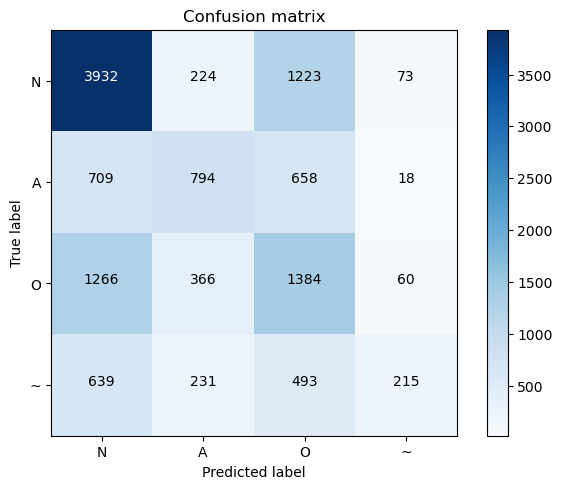

In [32]:
import itertools

# Extracting labels and counts
labels = ["N", "A", "O", "~"]
confusion_matrix = np.array([[matrix[row][col] for col in labels] for row in labels])

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix, classes=labels)
plt.show()

### Test Euclidean distance 

320943 320943
Full test
{'~': {'~': 0, 'O': 0, 'A': 0, 'N': 0}, 'O': {'~': 0, 'O': 0, 'A': 0, 'N': 0}, 'A': {'~': 0, 'O': 0, 'A': 0, 'N': 0}, 'N': {'~': 0, 'O': 0, 'A': 0, 'N': 0}}
Total results: 12285
Top1: 6261
Correct: 6736
Top 1 Accuracy: 50.964591%
Top 10 Accuracy: 54.831095%
0.41686287178088044


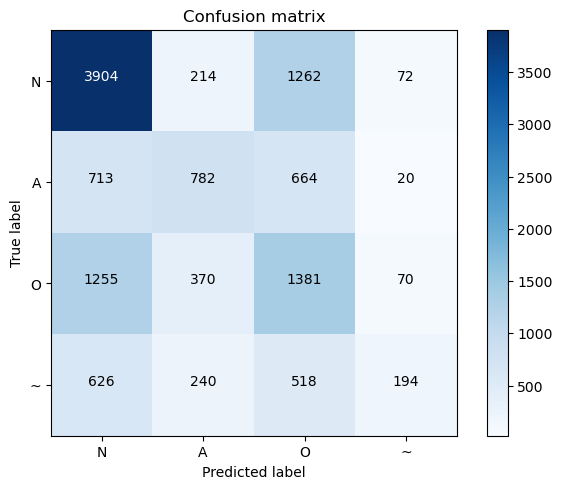

In [34]:

index_name = f'{index_base_name}-e'
index = get_pinecone_index(index_name, 'euclidean')

upload_vector(train_x, train_y, train_names)
print("Full test")

res, acc, matrix_e = run_test(index, test_x, test_y, "res_full")

f4 = 0
for k in set(test_y):
    small, big = 0, 0
    for j in set(test_y):
        small += matrix_e[k][j]
        big += matrix_e[j][k]
    f4 += 2 * matrix_e[k][k] / (small + big)

print(f4 / 4)

import itertools

# Extracting labels and counts
labels = ["N", "A", "O", "~"]
confusion_matrix = np.array([[matrix_e[row][col] for col in labels] for row in labels])

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix, classes=labels)
plt.show()

### Test dot product

320943 320943
Full test
{'~': {'~': 0, 'O': 0, 'A': 0, 'N': 0}, 'O': {'~': 0, 'O': 0, 'A': 0, 'N': 0}, 'A': {'~': 0, 'O': 0, 'A': 0, 'N': 0}, 'N': {'~': 0, 'O': 0, 'A': 0, 'N': 0}}
Total results: 12285
Top1: 4380
Correct: 4141
Top 1 Accuracy: 35.653236%
Top 10 Accuracy: 33.707774%
0.210363551145509


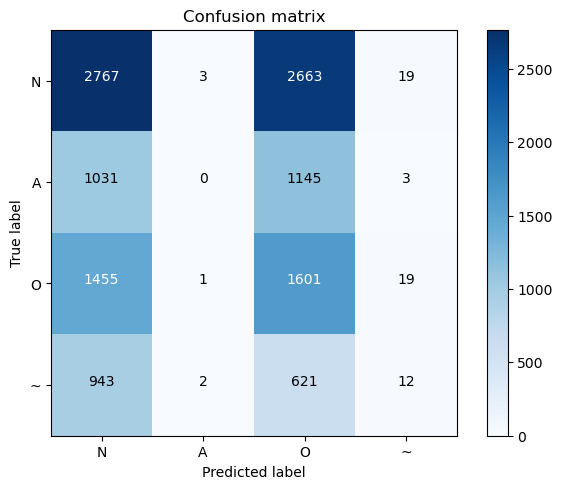

In [36]:

index_name = f'{index_base_name}-d'
index = get_pinecone_index(index_name, 'dotproduct')

upload_vector(train_x, train_y, train_names)
print("Full test")

res, acc, matrix_d = run_test(index, test_x, test_y, "res_full")

f4 = 0
for k in set(test_y):
    small, big = 0, 0
    for j in set(test_y):
        small += matrix_d[k][j]
        big += matrix_d[j][k]
    f4 += 2 * matrix_d[k][k] / (small + big)

print(f4 / 4)

import itertools

# Extracting labels and counts
labels = ["N", "A", "O", "~"]
confusion_matrix = np.array([[matrix_d[row][col] for col in labels] for row in labels])

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix, classes=labels)
plt.show()